<a href="https://colab.research.google.com/github/loisll/MMAI984/blob/main/lois_trainmodel_Team_Project_VQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#STEP 1: Import Libraries

In [1]:
# step 1: Import libraries
!pip install torch torchvision transformers
!pip install tqdm
import pandas as pd
from PIL import Image
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import zipfile
from google.colab import drive
import random
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import cv2
import re
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import nltk
import numpy as np
nltk.download('punkt')
import numpy as np
from tensorflow.keras.preprocessing import image
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import torch.nn.functional as F



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#STEP 2: LOAD TRAIN DATA

In [3]:
# Define function for loading questions and annotations

def load_data(data_file, feature):

  # Check if the file exists
  if os.path.exists(data_file):
    print("File found:", data_file)

    # Load the JSON file using the json module
    with open(data_file, 'r') as f:
        data = json.load(f)

    # Convert the JSON data to a DataFrame
    # questions = pd.DataFrame(data)

    # Flatten the JSON structure
    data = pd.json_normalize(data[feature])

    # Question preprocessing

    print("Data loaded successfully")
  else:
    print("File not found:", data_file)

  return data

In [4]:
# Load training questions

# Define the questions file
train_questions_file = os.path.join(data_path, 'train2015/MultipleChoice_abstract_v002_train2015_questions.json')
#train_questions_file = os.path.join(data_path)
train_questions_feature = 'questions'
train_questions = load_data(train_questions_file, train_questions_feature )




# Define the annotations file
train_annotations_file = os.path.join(data_path, 'train2015/abstract_v002_train2015_annotations.json')
train_annotations_feature = 'annotations'
train_annotations = load_data(train_annotations_file, train_annotations_feature)



# Define the annotations file
train_captions_file = os.path.join(data_path, 'train2015/captions_abstract_v002_train2015.json')
train_captions_feature = 'images'
train_captions = load_data(train_captions_file, train_captions_feature)



# Define the annotations file
train_OpenEnded_file = os.path.join(data_path, 'train2015/OpenEnded_abstract_v002_train2015_questions.json')
train_OpenEnded_feature = 'questions'
train_OpenEnded = load_data(train_OpenEnded_file, train_OpenEnded_feature)

File found: /content/drive/My Drive/Colab Notebooks/train2015/MultipleChoice_abstract_v002_train2015_questions.json
Data loaded successfully
File found: /content/drive/My Drive/Colab Notebooks/train2015/abstract_v002_train2015_annotations.json
Data loaded successfully
File found: /content/drive/My Drive/Colab Notebooks/train2015/captions_abstract_v002_train2015.json
Data loaded successfully
File found: /content/drive/My Drive/Colab Notebooks/train2015/OpenEnded_abstract_v002_train2015_questions.json
Data loaded successfully


2.2 MERGE TRAIN DATA

In [5]:
# Merge questions and answers

#train_data = pd.merge(train_questions, train_annotations, on='question_id')
train_data = pd.merge(train_questions, train_annotations, on=["image_id", "question_id"])

df_train = train_data.merge(train_captions, on='image_id')
df_train.head(5)

,image_id,question,multiple_choices,question_id,question_type,multiple_choice_answer,answers,answer_type,url,file_name,width,height
0,11779,Who looks happier?,"[alive, 1, woman, purple, 2, yes, white, boy, ...",117792,who,man,"[{'answer': 'old person', 'answer_confidence':...",other,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000011779.png,700,400
1,11779,Where is the woman sitting?,"[3, no, blue, red, 1, slide, monkey bars, jump...",117790,where is the,blanket,"[{'answer': 'on blanket', 'answer_confidence':...",other,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000011779.png,700,400
2,11779,Where is the man sitting?,"[away, yes, blue, 1, 2, mouse, couch, no, yell...",117791,where is the,bench,"[{'answer': 'on bench', 'answer_confidence': '...",other,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000011779.png,700,400
3,5536,Is this man hungry?,"[water, yellow, 4, running, blue, pouring, out...",55360,is this,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",yes/no,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000005536.png,700,400
4,5536,What kind of drink is that?,"[wine, girl would fall, soda, white, yes, coke...",55361,what kind of,soda,"[{'answer': 'water', 'answer_confidence': 'no'...",other,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000005536.png,700,400


# STEP 3 : EDA

From the above examples, we can see that most of the questions and answers are simple and clean text but some questions contain punctuation, common word contractions like what’s, it’s, they’re, etc, and noun contractions like guy’s, man’s, dog’s, etc., and some answers also contain punctuation. Hence, we need to perform the data cleaning operation on the question and answer dataset and expand contractions before performing EDA.

In [6]:

def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    phrase = re.sub(r"he\'s", "he is", phrase)
    phrase = re.sub(r"she\'s", "she is", phrase)
    phrase = re.sub(r"it\'s", "it is", phrase)

    phrase = re.sub(r"he\’s", "he is", phrase)
    phrase = re.sub(r"she\’s", "she is", phrase)
    phrase = re.sub(r"it\’s", "it is", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase


def text_preprocess(text):
    text = text.lower()
    text = decontractions(text) # replace contractions into natural form
    text = re.sub('[-,:]', ' ', text) # replace the character "-" "," with space
    text = re.sub("(?!<=\d)(\.)(?!\d)", '', text) # remove the character ".", except from floating numbers
    text = re.sub('[^A-Za-z0-9. ]+', '', text) # remove all punctuation, except A-Za-z0-9
    text = re.sub(' +', ' ', text) # remove extra space
    return text

# Question and Answer text preprocessing
df_train["question_preprocessed"] = df_train["question"].map(lambda x: text_preprocess(x))
df_train["answer_preprocessed"] = df_train["multiple_choice_answer"].map(lambda x: text_preprocess(x))

In [7]:
df_train.head(3)

,image_id,question,multiple_choices,question_id,question_type,multiple_choice_answer,answers,answer_type,url,file_name,width,height,question_preprocessed,answer_preprocessed
0,11779,Who looks happier?,"[alive, 1, woman, purple, 2, yes, white, boy, ...",117792,who,man,"[{'answer': 'old person', 'answer_confidence':...",other,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000011779.png,700,400,who looks happier,man
1,11779,Where is the woman sitting?,"[3, no, blue, red, 1, slide, monkey bars, jump...",117790,where is the,blanket,"[{'answer': 'on blanket', 'answer_confidence':...",other,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000011779.png,700,400,where is the woman sitting,blanket
2,11779,Where is the man sitting?,"[away, yes, blue, 1, 2, mouse, couch, no, yell...",117791,where is the,bench,"[{'answer': 'on bench', 'answer_confidence': '...",other,http://visualqa.org/data/abstract_v002/scene_i...,abstract_v002_train2015_000000011779.png,700,400,where is the man sitting,bench


# STEP 4 : Preprocess the Image--CNN

4.1. Encoding image size (batch size, channel, height, weight)


In [8]:
preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# 2. 加载图像并进行预处理
def load_images_from_folder(folder_path):
    images = []
    count_id = []
    for filename in os.listdir(folder_path): #get image from googledrive
     if filename in df_sample_5k["file_name"].values:
       #only choose 5k sample from googledrive that match selected dataframe
        if filename.endswith('.png'):  # only load PNG image
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path).convert('RGB')  # open and convert to  RGB
            image_tensor = preprocess(image)  # preprocssing as  Tensor
            images.append(image_tensor)
            count_id.append(filename.split('.')[0])
    return  torch.stack(images)  # 将所有 Tensor 拼接成一个批处理 (batch) 的 Tensor


4.2 Create CNN model and output as fully connected Layer (batch size, channel* height * weight)

In [9]:

# Step 2: CNN Model After Image Encoding
class CNNAfterEncoding(nn.Module):
    def __init__(self):
        super(CNNAfterEncoding, self).__init__()
        # Encoder (ResNet50)
         # First Conv Layer: 3 input channels (RGB), 16 output channels, 3x3 kernel size
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)

        # Second Conv Layer: 16 input channels, 32 output channels, 3x3 kernel size
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Max Pool Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected (hidden) layer: Flatten the input to fit the fully connected layer
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # 32 filters, 56x56 feature map size after pooling twice

        # Output layer: 128 input features, 10 output classes (example for classification)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Pass through first Conv layer followed by ReLU and Max Pooling
        x = self.pool(F.relu(self.conv1(x)))  # Output: (batch_size, 16, 112, 112)

        # Pass through second Conv layer followed by ReLU and Max Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Output: (batch_size, 32, 56, 56)

        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 32 * 56 * 56)  # Flatten to shape (batch_size, 32 * 56 * 56)

        # Pass through the fully connected hidden layer
        x = F.relu(self.fc1(x))  # Output: (batch_size, 128)

        # # Pass through the final output layer
        # x = self.fc2(x)  # Output: (batch_size, 10) - logits for 10 classes ...we dont need output for CNN

        return x



# STEP 5 : Preprocessing the Question --RNN

In [10]:

# 将问题文本转换为索引
def text_to_indices(df):
      all_questions = " ".join(df).split()
      unique_words = list(set(all_questions))
      word_to_index = {word: index for index, word in enumerate(unique_words)}
      vocab_size = len(word_to_index)  # 词汇表大小
      return [word_to_index[word] for word in all_questions if word in word_to_index]



max_length = 10# 填充索引以使其具有相同的长度（假设最大长度为10）

# question encoder
def question_encoder(text,max_length):
  questions_indices = [text_to_indices(question) for question in text ]
  questions_indices_padded = [q + [0] * (max_length - len(q)) if len(q) < max_length else q[:max_length] for q in questions_indices]
  questions_tensor = torch.tensor(questions_indices_padded, dtype=torch.long)# 将问题索引转换为 Tensor
  return questions_tensor





# 定义 QuestionEncoder 类
class QuestionEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(QuestionEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

    def forward(self, question):
        embedded = self.embedding(question)
        _, (hidden, _) = self.lstm(embedded)
        return hidden[-1]  # 返回最后一层的隐藏状态





# STEP 6 : Answer Encoder


In [11]:
# answers = df_sample_5k["answer_preprocessed"]

# # Step 2: Create a vocabulary of all unique words
# vocab = {word: idx for idx, word in enumerate(set(answers))}
# print("Vocabulary:", vocab)

# # Example Output: {'blue': 0, 'yes': 1, 'no': 2, 'maybe': 3, 'red': 4, 'definitely': 5, 'sometimes': 6, 'green': 7}

# # Step 3: Convert each answer into its corresponding index
# answer_indices = [torch.tensor([vocab[word]]) for word in answers]
# print("Answer Indices (before batching):", answer_indices)

# # Example Output: [tensor([1]), tensor([2]), tensor([3]), tensor([5]), tensor([1]), tensor([2]), ...]

# # Step 4: Pad the sequences to ensure they have the same length
# # Since these are single words, padding is not needed. But if the answers are sequences of different lengths:
# encoded_answers_tensor = torch.tensor(answer_indices)
# print(f"Encoded answers tensor: {encoded_answers_tensor.shape}")


def answer_encoder(answers):
       vocab = {word: idx for idx, word in enumerate(set(answers))}
       answer_indices = [torch.tensor([vocab[word]]) for word in answers]
       encoded_answers_tensor = torch.tensor(answer_indices)
       return encoded_answers_tensor


#step 7 :  Build VQA model

In [12]:


# VQA model: Combine image and question features and predict the answer
class VQAModel(nn.Module):
    def __init__(self, image_feat_size, question_feat_size, hidden_size, answer_vocab_size):
        super(VQAModel, self).__init__()
        self.fc1 = nn.Linear(image_feat_size + question_feat_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, answer_vocab_size)

    def forward(self, image_features, question_features):
        combined_features = torch.cat((image_features, question_features), dim=1) # COMBINE image fully connected layer and RNN fully connected layer
        x = torch.relu(self.fc1(combined_features))
        x = self.fc2(x)
        return x


# 7. VQA model

In [13]:
# Example usage
def main():
    # Hyperparameters
    vocab_size = 1000  # Example vocab size (should be equal to the number of unique tokens in your question dataset)
    embed_size = 300
    hidden_size = 512
    num_layers = 1
    answer_vocab_size = 100  # Example number of possible answers


    #question_encoder = QuestionEncoder(vocab_size, embed_size, hidden_size, num_layers)
    vqa_model = VQAModel(image_feat_size=128, question_feat_size=64, hidden_size=512, answer_vocab_size=answer_vocab_size)

    #flattened_image_features = image_batch.view(batch_size, -1)
    # Predict the answer
    result = vqa_model(output, question_features)
    #print("Model output (answer logits):", result.shape) #18,100

    # You would typically apply a softmax here to get answer probabilities
    predicted_answer = torch.argmax(result, dim=1)
    #print("Predicted answer index:", predicted_answer)



    # Use CrossEntropyLoss to compare logits and ground truth answers
    criterion = nn.CrossEntropyLoss()
    loss = criterion(result, encoded_answers_tensor)
    print(f"Loss: {loss.item()}")
    return loss.item()



In [15]:
# Define the data path
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/Colab Notebooks/'
# Define the path to your zip file and the extraction destination
extract_dir = os.path.join(data_path, 'train2015/train2015_images/scene_img_abstract_v002_train2015 (1)')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# STEP 8 : loop 5 times




In [ ]:
n_iterations = 1000
final_loss_result=[]
for i in range(n_iterations):
    print(f"Running model iteration {i + 1}")
    # get random 50 data
    batch_size=50
    df_sample_5k = df_train.sample(n=batch_size, replace=True, random_state=42)



    # 模型参数
    embed_size = 128     # 嵌入维度
    hidden_size = 64     # LSTM 隐藏层维度
    num_layers = 2       # LSTM 层数
    vocab_size = 100 #len(word_to_index)  # 词汇表大小
   # question feature , image feature and answer encoder
    image_batch = load_images_from_folder(extract_dir)
    model = CNNAfterEncoding()
    output = model(image_batch)#final fully connected layer output


    questions_tensor=question_encoder(df_sample_5k["question_preprocessed"],max_length = 10)
    model = QuestionEncoder(vocab_size, embed_size, hidden_size, num_layers)
    question_features = model(questions_tensor)# 前向传播，获取问题特征
    print(question_features.shape)


    encoded_answers_tensor=answer_encoder(df_sample_5k["answer_preprocessed"])

    main()
    lossitem=main()
    final_loss_result.append(lossitem)


Running model iteration 1
torch.Size([50, 64])
Loss: 4.616653919219971
Loss: 4.619462966918945
Running model iteration 2
torch.Size([50, 64])
Loss: 4.625426769256592
Loss: 4.591889381408691
Running model iteration 3
torch.Size([50, 64])
Loss: 4.609805583953857
Loss: 4.604868412017822
Running model iteration 4
torch.Size([50, 64])
Loss: 4.584681034088135
Loss: 4.6131415367126465
Running model iteration 5
torch.Size([50, 64])
Loss: 4.620275020599365
Loss: 4.605038642883301
Running model iteration 6
torch.Size([50, 64])
Loss: 4.60001277923584
Loss: 4.593937873840332
Running model iteration 7
torch.Size([50, 64])
Loss: 4.59846305847168
Loss: 4.607509136199951
Running model iteration 8
torch.Size([50, 64])
Loss: 4.618932723999023
Loss: 4.587910175323486
Running model iteration 9
torch.Size([50, 64])
Loss: 4.599003791809082
Loss: 4.617092132568359
Running model iteration 10
torch.Size([50, 64])
Loss: 4.620975017547607
Loss: 4.598250389099121
Running model iteration 11
torch.Size([50, 64])
Lo

In [18]:
 print(f'Average CrossEntropyLoss: ',sum(final_loss_result)/n_iterations)

Average CrossEntropyLoss:  4.606250356197357


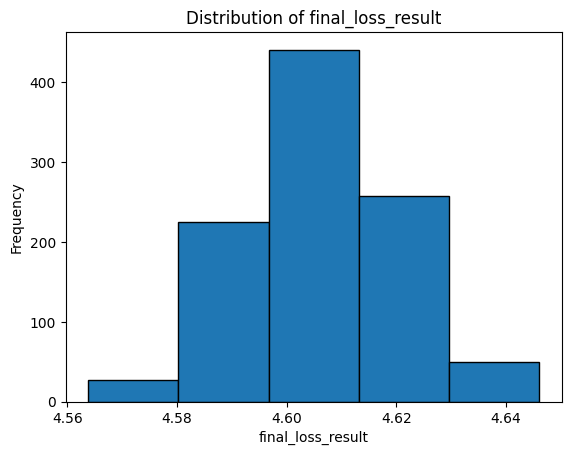

In [20]:
# Plotting the histogram
plt.hist(final_loss_result, bins=5, edgecolor='black')

# Adding labels and title
plt.title('Distribution of final_loss_result')
plt.xlabel('final_loss_result')
plt.ylabel('Frequency')

# Display the plot
plt.show()